In [113]:
####################################
#                                  #
#  paging_burden.ipynb             #
#  Akhil Garg, akhil@akhilgarg.ca  #
#  Created 2023-08-22              #
#                                  #
####################################

'''
Takes in a gmail SMS log as a .mbox file
and plots the number of pages per day.
'''

import pandas  as pd
import numpy   as np
import mailbox as mb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Import SMS/pages

In [47]:
mail_list = mb.mbox('page_log.mbox')
SMS_list  = []
page_message = ''
timestamp    = ''
hospital     = ''

for message in mail_list:
    
    # Skip non SMS emails
    if 'SMS' not in message['X-Gmail-Labels'].split(','): continue    
        
    # Analyze pages only from the Jewish General Hospital
    if ('15146170125'  in message['X-smssync-address']):
        page_message = message.get_payload().strip().split(' - ')[-1]
        timestamp = pd.to_datetime(message['Date']).tz_localize(None)
        hospital = 'JGH'
    
    # Analyze pages from the McGill University Health Centre
    elif ('5146131773'  in message['X-smssync-address']):
        page_message = message.get_payload().strip()
        timestamp = pd.to_datetime(message['Date']).tz_localize(None)
        hospital = 'MUHC'
        
    else: continue
            
    SMS_dict = {}
    SMS_dict.update({'Message':page_message,'Timestamp':timestamp,'Hospital':hospital})
    SMS_list.append(SMS_dict)
        
page_log = pd.DataFrame(SMS_list)
page_log

,Message,Timestamp,Hospital
0,22488,2023-08-02 10:56:47,JGH
1,23826,2023-08-02 10:34:58,JGH
2,20679,2023-08-02 10:18:29,JGH
3,26551,2023-08-02 09:27:43,JGH
4,26551,2023-08-02 09:20:02,JGH
...,...,...,...
545,"5149341934,,,,,,,45536 D10",2023-07-16 14:40:57,MUHC
546,"514-934-1934,,,,,,,36759 CONNEY FROM MICROB",2023-07-16 11:11:26,MUHC
547,"514-934-1934,,,,,,,71797 ASHLEY OBS",2023-07-16 10:47:45,MUHC
548,"5149341934,,,,,38079 er",2023-07-15 14:57:44,MUHC


# Process SMS/pages

<Axes: xlabel='Timestamp'>

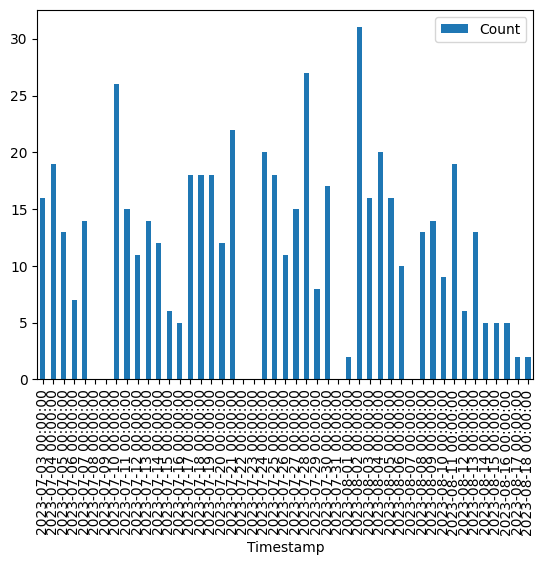

In [76]:
hourly_group = page_log.groupby(
    [pd.Grouper(key='Timestamp',freq='H'),page_log.Hospital]) \
    .size() \
    .reset_index(name='Count') \
    .set_index('Timestamp') \
    .asfreq(freq='H')

# Plot pages per day
daily_group = page_log.groupby(
    [pd.Grouper(key='Timestamp',freq='D'),page_log.Hospital]) \
    .size() \
    .reset_index(name='Count') \
    .set_index('Timestamp') \
    .asfreq(freq='D')
daily_group.plot.bar()

In [81]:
# Plot pages per day
daily_group = page_log.groupby(
    [pd.Grouper(key='Timestamp',freq='D'),page_log.Hospital]) \
    .size() \
    .reset_index(name='Count') \
    .set_index('Timestamp') \
    .asfreq(freq='D')
daily_group

,Hospital,Count
Timestamp,,
2023-07-03,MUHC,16.0
2023-07-04,MUHC,19.0
2023-07-05,MUHC,13.0
2023-07-06,MUHC,7.0
2023-07-07,MUHC,14.0
2023-07-08,NaN,NaN
2023-07-09,NaN,NaN
2023-07-10,MUHC,26.0
2023-07-11,MUHC,15.0


## Daily graph

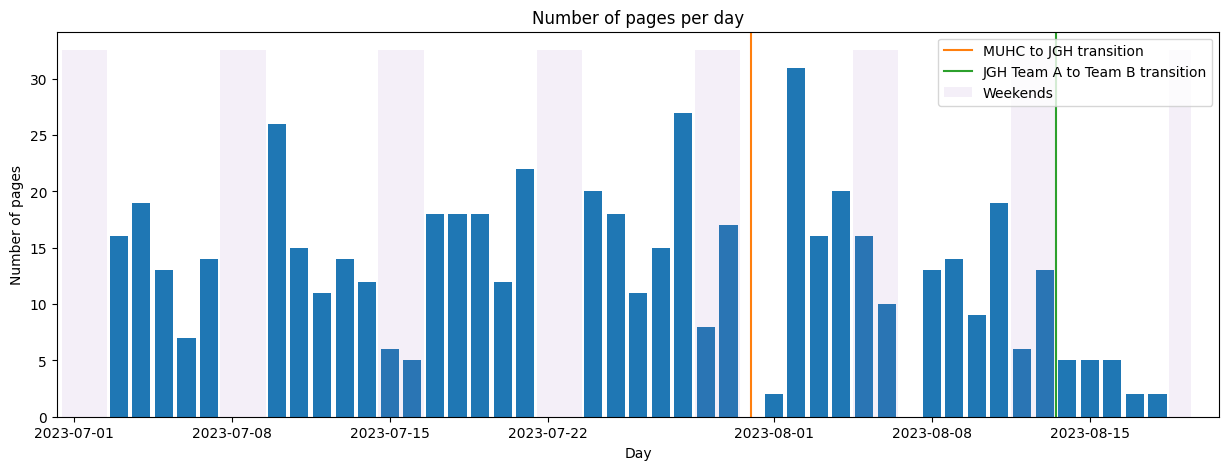

In [132]:
fig, ax = plt.subplots(figsize=(15,5))

color_dict = {'JGH':'red','MUHC':'blue',np.nan:'white'}

ax.bar(daily_group.index,daily_group['Count'])

ax.set_xlabel('Day')
ax.set_ylabel('Number of pages')
ax.set_title ('Number of pages per day')

# Add vertical lines for transitions
ax.axvline(pd.to_datetime('2023-07-31'),
           color='C1',
           label='MUHC to JGH transition')

ax.axvline(pd.to_datetime('2023-08-13 12:00'),
           color='C2',
           label='JGH Team A to Team B transition')

# Add shading to weekends
xmin, xmax = ax.get_xlim()
days = np.arange(np.floor(xmin), np.ceil(xmax))
weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
days = days-.5 #offset shading to match bars
ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor='C4', alpha=.1, label='Weekends')
ax.set_xlim(xmin, xmax) # set limits back to default values

# Show legend
ax.legend()

plt.show()